In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Load all of the station ID #s into a list.
data_dir = "../data/stations/"
station_filenames_list = os.listdir(path=data_dir)

station_ids_list = list(set(list(
    int(fname.split("_")[1].split(".")[0])
    for fname in station_filenames_list
    if ("UN" not in fname) and ("Store" not in fname)
)))
print(len(station_ids_list))

115


In [5]:
# Define the column names. This names are pretty much identical to those in the CSV (I actually loaded the CSV,
# printed the names, and then compiled them into this list). It's just easier to do the formatting by creating the list
# here and then redefining the dataframe column names with them later.
column_names_list = ["station_id", "date", "name", "value", "range_flag", "door_flag", "frozen_flag", "manual_flag"]

# Ingest CSV containing all of the CRN ACCLIMA soil moisture data for the United States.
df = pd.read_csv(
    "../data/acclima_soil_water_rleeper_FULL.csv",
    header="infer",
    index_col=False
)

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head()

,WBANNO,UTC_START,NAME,VALUE,RANGE_FLAG,DOOR_FLAG,FROZEN_FLAG,MANUAL_FLAG,TAGS
0,3047,2017-05-01 00:00:00,p_official,0.000,0,0,0,0,NaN
1,3047,2017-05-01 00:00:00,t_official,22.261,0,0,0,0,NaN
2,3047,2017-05-01 01:00:00,p_official,0.000,0,0,0,0,NaN
3,3047,2017-05-01 01:00:00,t_official,19.647,0,0,0,0,NaN
4,3047,2017-05-01 02:00:00,p_official,0.000,0,0,0,0,NaN


In [13]:
df.TAGS.value_countsounts()

Acclima-Scaling, Acclima-Too high                             137418
Acclima-Erratic, Acclima-Too high                              54363
Acclima-Noise                                                  49797
Acclima-Zero                                                   38720
Acclima-Erratic                                                37692
Acclima-Failure, Acclima-Zero                                  23223
Acclima-Zero, Acclima-Zero                                     13024
Acclima-NoPrcpResponse, Acclima-Too high                       12988
Acclima-Noise, Acclima-Zero                                    11147
Acclima-Failure, Acclima-Static, Acclima-Zero                   9551
Acclima-Too high                                                9413
Acclima-Diurnal Noise                                           8501
Acclima-Spike                                                   7508
Acclima-Erratic, Acclima-Zero                                   7251
Acclima-Erratic, Acclima-Too high,

In [9]:
tags_list = df.TAGS.unique()

tags_list = list(tags_list)[1:]

print(tags_list)

In [16]:
# Drop tuniqueolumn "TAGS" and then rename the rest of the columns.
df = df.drop(columns=["TAGS"])
df.columns = column_names_list

# Preview the dataframe.
df.head()

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station_id,date,name,value,range_flag,door_flag,frozen_flag,manual_flag
0,3047,2017-05-01 00:00:00,p_official,0.000,0,0,0,0
1,3047,2017-05-01 00:00:00,t_official,22.261,0,0,0,0
2,3047,2017-05-01 01:00:00,p_official,0.000,0,0,0,0
3,3047,2017-05-01 01:00:00,t_official,19.647,0,0,0,0
4,3047,2017-05-01 02:00:00,p_official,0.000,0,0,0,0


In [17]:
######### WORKS ##########
# Create a list of the numerical station ID #'s converted from strings to ints.
new_station_ids = [
    int(stat_id)
    if stat_id!="UN" else stat_id
    for stat_id in df.station_id.values
]

# Make these integer station ID #s the actual values in the dataframe.
df.station_id = new_station_ids

# Create an array of all unique station IDs.
station_id_array = df.station_id.unique()

# Convert all values in "date" column to datetime objects.
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d %H:%M:%S',)

In [4]:
########## DOESN'T WORK ##########
# # Pivot the station's data and target values into ML-compatible arrays. 
# df_data =\
#     df.pivot(index="date", columns="name", values="value")

# # Create the class labels DF for the station.
# df_station_targets =\
#     df.pivot(
#         index="date", columns="name", values="manual_flag"
#     )

# # Create a precipitation and temperature DF.
# df_station_pt_data = df_station_data[["p_official", "t_official"]]

# # Drop irrelevant columns from the DFs.
# df_station_data = df_station_data.drop(
#         columns=["p_official", "t_official"]
#     )
# df_station_targets = df_station_targets.drop(
#         columns=["p_official", "t_official"]
#     )

# # Get rid of rows of missing data and then drop those rows from the targets dataframe.
# df_station_data = df_station_data.dropna(how="all")
# df_station_pt_data = df_station_pt_data.loc[df_station_data.index]
# df_station_targets = df_station_targets.loc[df_station_data.index]

# # Add the precip and temp data back onto the station data.
# df_station_data["p_official"] = df_station_pt_data["p_official"]
# df_station_data["t_official"] = df_station_pt_data["t_official"]

In [18]:
# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    test_station_id : None
    for test_station_id in station_id_array
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

In [19]:
station_id = station_id_array[0]
pd.read_csv(data_dir+f"data_{station_id}.csv", index_col="date")

,sw1005,sw1010,sw1020,sw1050,sw1100,sw2005,sw2010,sw2020,sw2050,sw2100,sw3005,sw3010,sw3020,sw3050,sw3100,p_official,t_official
date,,,,,,,,,,,,,,,,,
2018-03-03 21:00:00,0.007,0.038,0.037,0.042,0.034,0.006,12.597,0.035,0.043,0.025,0.013,-12.632,0.030,0.039,0.040,NaN,NaN
2018-03-03 22:00:00,0.008,0.049,0.048,0.057,0.047,0.007,17.000,0.048,0.059,0.035,0.015,18.290,0.043,0.051,0.053,NaN,NaN
2018-03-03 23:00:00,0.008,0.050,0.048,0.057,0.046,0.009,-99999.000,0.049,0.060,0.036,0.015,-99999.000,0.043,0.052,0.051,0.0,25.548
2018-03-04 00:00:00,0.010,0.050,0.049,0.057,0.047,0.008,-99999.000,0.049,0.059,0.036,0.014,-99999.000,0.044,0.051,0.051,0.0,23.120
2018-03-04 01:00:00,0.008,0.051,0.048,0.058,0.048,0.007,-99999.000,0.049,0.058,0.037,0.012,-99999.000,0.044,0.052,0.053,0.0,20.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-28 08:00:00,0.014,0.024,0.030,0.038,0.038,0.016,0.033,0.031,0.040,0.030,0.014,0.020,0.025,0.000,0.043,0.0,25.418
2020-07-28 09:00:00,0.012,0.022,0.029,0.038,0.037,0.015,0.035,0.032,0.040,0.031,0.014,0.020,0.026,0.000,0.042,0.0,24.940
2020-07-28 10:00:00,0.011,0.021,0.031,0.039,0.037,0.012,0.034,0.031,0.037,0.030,0.014,0.019,0.026,0.000,0.042,0.0,24.558


In [20]:
for station_id in station_id_array:
    temp_feats_df = pd.read_csv(
        data_dir+f"data_{station_id}.csv",
        index_col="date"
    )
    temp_feats_df.index = pd.to_datetime(temp_feats_df.index, format="%Y-%m-%d %H:%M:%S")
    features_dict[station_id] = temp_feats_df
    
    temp_targs_df = pd.read_csv(
        data_dir+f"targets_{station_id}.csv",
        index_col="date"
    )
    temp_targs_df.index = pd.to_datetime(temp_targs_df.index, format="%Y-%m-%d %H:%M:%S")
    targets_dict[station_id] = temp_targs_df

# Explore!

In [21]:
# Print all the stations that have flagged anomalies (most stations are good, well-behaved little stations).
for idx in range(len(station_id_array)):
    stat_feats = features_dict[station_id_array[idx]]
    stat_targs = targets_dict[station_id_array[idx]]
    total_anoms = stat_targs.sum().sum()
    if total_anoms > 0:
        print(str(idx), str(total_anoms))

11 61365.0
14 6.0
18 2832.0
28 46212.0
31 1.0
33 730.0
34 154.0
36 2.0
40 1443.0
44 3097.0
52 3079.0
54 2.0
56 16338.0
62 7941.0
68 77606.0
70 64.0
71 45.0
78 11671.0
79 38.0
80 8861.0
81 9379.0
84 103.0
85 23450.0
88 59056.0
89 101487.0
91 1.0
95 23240.0
96 10030.0
102 5100.0
113 2281.0
115 30.0


In [22]:
# Isolate the features and targets for a single station and then see how many anomalies there are.
idx = 11
stat_feats = features_dict[station_id_array[idx]]
stat_targs = targets_dict[station_id_array[idx]]

good_data_idxs = (stat_feats["sw1005"] > 0) & (stat_feats["sw2005"] > 0)

X = stat_feats[good_data_idxs].loc[:,"sw1005"]
Y = stat_feats[good_data_idxs].loc[:,"sw2005"]

x = stat_targs[good_data_idxs].loc[:, "sw1005"]
y = stat_targs[good_data_idxs].loc[:, "sw2005"]

norm_idxs_x = (x == 0)
norm_idxs_y = (y == 0)

x_norminal = x.loc[norm_idxs_x]
y_norminal = y.loc[norm_idxs_y]

x_anominal = x.loc[~norm_idxs_x]
y_anominal = x.loc[~norm_idxs_y]

print(x_anominal)
print(y_anominal)

date
2019-09-19 17:00:00    1.0
2019-09-19 18:00:00    1.0
Name: sw1005, dtype: float64
Series([], Name: sw1005, dtype: float64)


In [35]:
stat_targs.sum()

sw1005    12301.0
sw1010    12266.0
sw1020    12266.0
sw1050    12266.0
sw1100    12266.0
sw2005        0.0
sw2010        0.0
sw2020        0.0
sw2050        0.0
sw2100        0.0
sw3005        0.0
sw3010        0.0
sw3020        0.0
sw3050        0.0
sw3100        0.0
dtype: float64

# Hmmmmmm. Time for a different approach.

Alright, time for a different approach. If you look at how many anomalies are present for individual depths in individual holes, it's very few.

So, a more efficient approach will be to combine all of the holes and depths using PCA for the features and boolean logic for the targets, and then back-track which depths seem to contribute more via total combined variance proportions.

In [23]:
test = stat_feats.drop(columns=["p_official", "t_official"])
print((test == -999).sum().sum())

30705


In [24]:
# Drop all but the soil moisture measurements and replace the values with the mean of each row.
feats_cleaned = stat_feats.drop(columns=["p_official", "t_official"]).dropna(how="any")
feats_cleaned = feats_cleaned.replace(to_replace=-999, value=pd.NA)
feats_cleaned = feats_cleaned.replace(to_replace=-9.99, value=pd.NA)
# The following line of commented-out code doesn't work.
# # feats_cleaned.fillna(value=feats_cleaned.mean(axis=1), axis=1)
# The following line of code, however, does work.
# From https://stackoverflow.com/questions/33058590/pandas-dataframe-replacing-nan-with-row-average.
# # df.T.fillna(df.mean(axis=1)).T
feats_cleaned = feats_cleaned.T.fillna(feats_cleaned.mean(axis=1)).T

0.9604719068575898


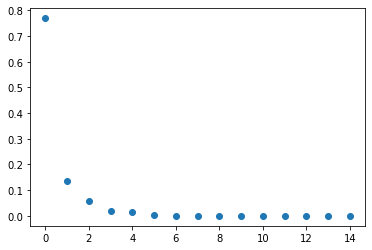

In [25]:
# Fit the PCA function and then plot the explained variance ratio.
pca = PCA()
feats_PCA = pca.fit_transform(feats_cleaned.values)
evr = pca.explained_variance_ratio_
plt.scatter([i for i in range(len(evr))], evr)
print(sum(evr[:3]))

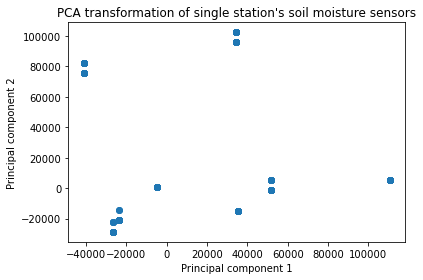

In [142]:
pc0, pc1, pc2 = (feats_PCA[:, i] for i in range(3))

plt.scatter(pc1, pc2)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

plt.title("PCA transformation of single station's soil moisture sensors")

plt.tight_layout()

plt.savefig("../plots/PCA_fit_transform_singlestation_sensors.png", dpi=300)
plt.show()

Notice what happens when we PCA everything without scaling according to station first. Pretty silly looking!

# Scale by station first and then re-run PCA

In [27]:
stat_id = station_id_array[0]
df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
df_to_scale.head()

,sw1005,sw1010,sw1020,sw1050,sw1100,sw2005,sw2010,sw2020,sw2050,sw2100,sw3005,sw3010,sw3020,sw3050,sw3100
date,,,,,,,,,,,,,,,
2018-03-03 21:00:00,0.007,0.038,0.037,0.042,0.034,0.006,12.597,0.035,0.043,0.025,0.013,-12.632,0.030,0.039,0.040
2018-03-03 22:00:00,0.008,0.049,0.048,0.057,0.047,0.007,17.000,0.048,0.059,0.035,0.015,18.290,0.043,0.051,0.053
2018-03-03 23:00:00,0.008,0.050,0.048,0.057,0.046,0.009,-99999.000,0.049,0.060,0.036,0.015,-99999.000,0.043,0.052,0.051
2018-03-04 00:00:00,0.010,0.050,0.049,0.057,0.047,0.008,-99999.000,0.049,0.059,0.036,0.014,-99999.000,0.044,0.051,0.051
2018-03-04 01:00:00,0.008,0.051,0.048,0.058,0.048,0.007,-99999.000,0.049,0.058,0.037,0.012,-99999.000,0.044,0.052,0.053


In [28]:
# Check for fill-values of -99999.
print((df_to_scale==-99999).sum().sum())

22593


In [29]:
# Check for negative values that aren't -99999.
print(print(((df_to_scale < 0) & (df_to_scale!=-99999)).sum()))
print()
print(df_to_scale[(df_to_scale < 0) & (df_to_scale!=-99999)].sum())
print()
print(df_to_scale.loc[((df_to_scale["sw2020"] < 0) & (df_to_scale["sw2020"]!=-99999)), "sw2020"].sum())

sw1005    0
sw1010    0
sw1020    0
sw1050    0
sw1100    0
sw2005    0
sw2010    0
sw2020    1
sw2050    0
sw2100    0
sw3005    0
sw3010    1
sw3020    0
sw3050    0
sw3100    0
dtype: int64
None

sw1005     0.000
sw1010     0.000
sw1020     0.000
sw1050     0.000
sw1100     0.000
sw2005     0.000
sw2010     0.000
sw2020   -34.410
sw2050     0.000
sw2100     0.000
sw3005     0.000
sw3010   -12.632
sw3020     0.000
sw3050     0.000
sw3100     0.000
dtype: float64

-34.41


Now I'll scale this station's data after filling in the NaN values column-wise.

In [30]:
df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
df_to_scale[(df_to_scale == -99999)] = pd.NA
df_to_scale = df_to_scale.interpolate(method="time", axis=0)
df_to_scale.head(n=10)

,sw1005,sw1010,sw1020,sw1050,sw1100,sw2005,sw2010,sw2020,sw2050,sw2100,sw3005,sw3010,sw3020,sw3050,sw3100
date,,,,,,,,,,,,,,,
2018-03-03 21:00:00,0.007,0.038,0.037,0.042,0.034,0.006,12.597000,0.035,0.043,0.025,0.013,-12.632000,0.030,0.039,0.040
2018-03-03 22:00:00,0.008,0.049,0.048,0.057,0.047,0.007,17.000000,0.048,0.059,0.035,0.015,18.290000,0.043,0.051,0.053
2018-03-03 23:00:00,0.008,0.050,0.048,0.057,0.046,0.009,16.998153,0.049,0.060,0.036,0.015,18.288009,0.043,0.052,0.051
2018-03-04 00:00:00,0.010,0.050,0.049,0.057,0.047,0.008,16.996305,0.049,0.059,0.036,0.014,18.286018,0.044,0.051,0.051
2018-03-04 01:00:00,0.008,0.051,0.048,0.058,0.048,0.007,16.994458,0.049,0.058,0.037,0.012,18.284027,0.044,0.052,0.053
2018-03-04 02:00:00,0.007,0.050,0.048,0.058,0.046,0.007,16.992610,0.050,0.059,0.035,0.012,18.282037,0.045,0.051,0.053
2018-03-04 03:00:00,0.007,0.051,0.049,0.058,0.047,0.003,16.990763,0.050,0.059,0.034,0.012,18.280046,0.045,0.051,0.052
2018-03-04 04:00:00,0.007,0.050,0.050,0.058,0.047,0.002,16.988915,0.050,0.059,0.036,0.012,18.278055,0.044,0.051,0.051
2018-03-04 05:00:00,0.007,0.050,0.049,0.058,0.047,0.001,16.987068,0.050,0.060,0.035,0.012,18.276064,0.044,0.051,0.053


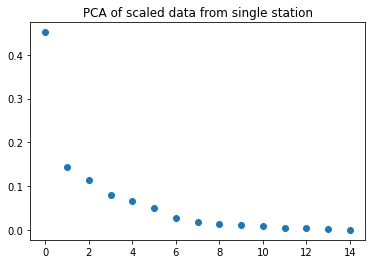

0.595874539944261


In [31]:
df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
df_to_scale[(df_to_scale == -99999)] = pd.NA
df_to_scale = df_to_scale.interpolate(method="time", axis=0)

scaler = StandardScaler(with_mean=False)
feats_scaled_array = scaler.fit_transform(df_to_scale)

pca = PCA()
feats_pca_scaled_array = pca.fit_transform(feats_scaled_array)

evr = pca.explained_variance_ratio_
x = [i for i in range(len(evr))]
plt.scatter(x, evr)
plt.title("PCA of scaled data from single station")
plt.show()
print(sum(evr[:2]))

Well, check that out! The variance is really well distributed accross the PCs! If that holds for the sensor network in general, that would indicate that the sensors are really well-designed, with each hole and depth potentially contributing distinct information.

Time to iterate over all the stations and concatenate the resulting datasets. I'll PCA them together and then plot to try and get a sense of variance, etc.

# Scale all stations' data and concatenate to a single dataframe for PCA

In [39]:
scaled_feats_dict = {
    stat_id : None
    for stat_id in station_id_array
    if features_dict[stat_id].shape[1]==15
}
for stat_id in station_id_array:
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    if df_to_scale.shape[1]==15:
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_array)
    else:
        continue

t = [stat_tuple[1] for stat_tuple in scaled_feats_dict.items()]
scaled_feats_array = np.concatenate(t, axis=0)

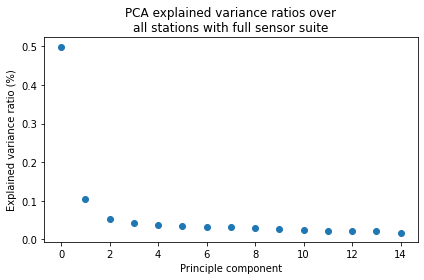

The first 3 explain 0.655638718650765 of the variance.


In [143]:
pca = PCA()
pca_scaled_feats_array = pca.fit_transform(scaled_feats_array)
evr = pca.explained_variance_ratio_
x = [i for i in range(len(evr))]
plt.scatter(x, evr)
plt.title("PCA explained variance ratios over\nall stations with full sensor suite")
plt.xlabel("Principle component")
plt.ylabel("Explained variance ratio (%)")

plt.tight_layout()
plt.savefig("../plots/PCA_EVR_allstations_allsensors.png", dpi=300)
plt.show()
num_PC_to_sum = 3
print("The first", num_PC_to_sum, "explain", sum(evr[:num_PC_to_sum]), "of the variance.")

In [235]:
# scaled_feats_dict = {
#     stat_id : None
#     for stat_id in station_id_array
# }
# # for stat_id in station_id_array:

# Concatenate anomaly data for ML

In [75]:
targs_dict = {
    stat_id : None
    for stat_id in station_id_array
    if features_dict[stat_id].shape[1]==15
}
for stat_id in station_id_array:
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    if df_to_scale.shape[1]==15:
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

In [82]:
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

# This takes a COUPLE MINUTES TO RUN. So, only re-run if necessary!!
# # combined_scaledfeats_targs_df.to_csv("../data/combined_scaledfeats_targs_df.csv")

In [94]:
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

In [95]:
# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -15:]
ml_1D_targs_series = ml_targs_df.sum(axis=1)
ml_1D_targs_series[ml_1D_targs_series > 1] = 1

In [116]:
# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

In [117]:
# # Save the ML-ready features and targets.
# ml_targs_df.to_pickle("../data/ml_targs_df.pickle")
# ml_1D_targs_series.to_pickle("../data/ml_1D_targs_series.pickle")
# ml_feats_df.to_pickle("../data/ml_feats_df.pickle")

### Calculate the percentage of the ML-ready data that are anomalies

In [113]:
percentage_anomalies =\
    np.round(100*ml_1D_targs_series.sum()/ml_1D_targs_series.shape[0], 2)
print(f"{percentage_anomalies}% of the data are anomalies.")

10.22% of the data are anomalies.


# Attempt some ML! Yewwwwww!

In [128]:
import seaborn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [122]:
# # Define the parameter ranges, over which the grid search algorithm will scan, 
# # for the number of estimators (ie, the number of decision trees) in the random forest.
# N_ESTIMATORS = [25, 50, 100, 200,]

# # Define the range of max tree depths over which to search.
# MAX_DEPTH = [5, 10, 50, None]

# # Take the two parameter lists we defined above and include them in a parameter
# # grid that will be fed to scklearn's GridSearchCV object for hyperparameter
# # optimization.
# param_grid = [
#     {
#         "n_estimators":N_ESTIMATORS,
#         "max_depth":MAX_DEPTH,
#     }
# ]

# # Define a GridSearchCV object that will optimize a random forest classfier over
# # our previously defined parameter grid. Set the grid search object to use 5-fold
# # cross-validation and to take advantage of all of the available processors for
# # running the search.
# gridsearch_rf = GridSearchCV(
#     RandomForestClassifier(),
#     param_grid,
#     cv=5,
#     n_jobs=-1,
# )

# # Run the search on the features and the merged classes.
# gridsearch_rf.fit(ml_feats_df.values, ml_1D_targs_series.values)

# # Print the best parameters from the grid search and the best score.
# print("Best parameters:", gridsearch_rf.best_params_)
# print("Best score:", gridsearch_rf.best_score_)

In [138]:
ml_1D_targs_series.shape

(1678756,)

In [125]:
X = ml_feats_df.values
y = ml_1D_targs_series.values

# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
for idx, (train, test) in enumerate(stratified_kfold_generator.split(X, y)):
    
    print(idx)
    
    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y[test].ravel(), y_predicted_rf.ravel()))

0
1
2
3
4


/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


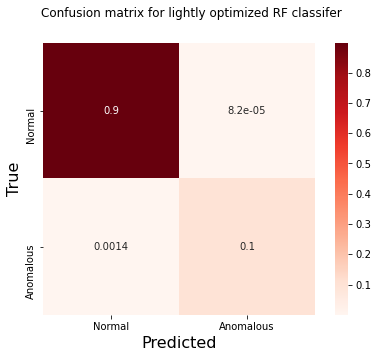

In [134]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

In [137]:
cf_rf[1][0]/cf_rf[1][1]

0.013448703561514381

In [145]:
cf_rf[1][1]/(ml_1D_targs_series.sum()/ml_1D_targs_series.shape[0])

0.9867297639098533